In [21]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Optional, List, Tuple
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from alns import ALNS
from alns.accept import SimulatedAnnealing
from alns.select import AlphaUCB
from alns.stop import MaxIterations, MaxRuntime

# Set random seed for reproducibility
SEED = 2345
rnd.seed(SEED)

@dataclass
class Data:
    n_jobs: int
    n_machines: int
    bkv: int  # best known value
    processing_times: np.ndarray

    @classmethod
    def from_file(cls, path):
        with open(path, "r") as fi:
            lines = fi.readlines()

            n_jobs, n_machines, _, bkv, _ = [
                int(num) for num in lines[1].split()
            ]
            processing_times = np.genfromtxt(lines[3:], dtype=int)

            return cls(n_jobs, n_machines, bkv, processing_times)


def compute_completion_times(schedule):
    """
    Compute the completion time for each job of the passed-in schedule.
    """
    completion = np.zeros(DATA.processing_times.shape, dtype=int)

    for idx, job in enumerate(schedule):
        for machine in range(DATA.n_machines):
            prev_job = completion[machine, schedule[idx - 1]] if idx > 0 else 0
            prev_machine = completion[machine - 1, job] if machine > 0 else 0
            processing = DATA.processing_times[machine, job]

            completion[machine, job] = max(prev_job, prev_machine) + processing

    return completion


def compute_makespan(schedule):
    """
    Returns the makespan, i.e., the maximum completion time.
    """
    return compute_completion_times(schedule)[-1, schedule[-1]]


def plot(schedule, name):
    """
    Plots a Gantt chart of the schedule for the permutation flow shop problem.
    """
    n_machines, n_jobs = DATA.processing_times.shape

    completion = compute_completion_times(schedule)
    start = completion - DATA.processing_times

    # Plot each job using its start and completion time
    cmap = plt.colormaps["rainbow"].resampled(n_jobs)
    machines, length, start_job, job_colors = zip(
        *[
            (i, DATA.processing_times[i, j], start[i, j], cmap(j - 1))
            for i in range(n_machines)
            for j in range(n_jobs)
        ]
    )

    _, ax = plt.subplots(1, figsize=(12, 6))
    ax.barh(machines, length, left=start_job, color=job_colors)

    ax.set_title(f"{name}\n Makespan: {compute_makespan(schedule)}")
    ax.set_ylabel(f"Machine")
    ax.set_xlabel(f"Completion time")
    ax.set_yticks(range(DATA.n_machines))
    ax.set_yticklabels(range(1, DATA.n_machines + 1))
    ax.invert_yaxis()

    plt.show()


class Solution:
    def __init__(
        self, schedule: List[int], unassigned: Optional[List[int]] = None
    ):
        self.schedule = schedule
        self.unassigned = unassigned if unassigned is not None else []

    def objective(self):
        return compute_makespan(self.schedule)

    def insert(self, job: int, idx: int):
        self.schedule.insert(idx, job)

    def opt_insert(self, job: int):
        """
        Optimally insert the job in the current schedule.
        """
        idcs_costs = all_insert_cost(self.schedule, job)
        idx, _ = min(idcs_costs, key=lambda idx_cost: idx_cost[1])
        self.insert(job, idx)

    def remove(self, job: int):
        self.schedule.remove(job)


def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
    """
    Computes all partial makespans when inserting a job in the schedule.
    O(nm) using Taillard's acceleration. Returns a list of tuples of the
    insertion index and the resulting makespan.

    [1] Taillard, E. (1990). Some efficient heuristic methods for the
    flow shop sequencing problem. European Journal of Operational Research,
    47(1), 65-74.
    """
    k = len(schedule) + 1
    m = DATA.processing_times.shape[0]
    p = DATA.processing_times

    # Earliest completion of schedule[j] on machine i before insertion
    e = np.zeros((m + 1, k))
    for j in range(k - 1):
        for i in range(m):
            e[i, j] = max(e[i, j - 1], e[i - 1, j]) + p[i, schedule[j]]

    # Duration between starting time and final makespan
    q = np.zeros((m + 1, k))
    for j in range(k - 2, -1, -1):
        for i in range(m - 1, -1, -1):
            q[i, j] = max(q[i + 1, j], q[i, j + 1]) + p[i, schedule[j]]

    # Earliest relative completion time
    f = np.zeros((m + 1, k))
    for l in range(k):
        for i in range(m):
            f[i, l] = max(f[i - 1, l], e[i, l - 1]) + p[i, job]

    # Partial makespan; drop the last (dummy) row of q
    M = np.max(f + q, axis=0)

    return [(idx, M[idx]) for idx in np.argsort(M)]


def random_removal(state: Solution, rng, n_remove=3) -> Solution:
    """
    Randomly remove a number jobs from the solution.
    """
    destroyed = deepcopy(state)

    for job in rng.choice(DATA.n_jobs, n_remove, replace=False):
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def adjacent_removal(state: Solution, rng, n_remove=3) -> Solution:
    """
    Randomly remove a number adjacent jobs from the solution.
    """
    destroyed = deepcopy(state)

    start = rng.integers(DATA.n_jobs - n_remove)
    jobs_to_remove = [state.schedule[start + idx] for idx in range(n_remove)]

    for job in jobs_to_remove:
        destroyed.unassigned.append(job)
        destroyed.schedule.remove(job)

    return destroyed


def greedy_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Greedily insert the unassigned jobs back into the schedule. The jobs are
    inserted in non-decreasing order of total processing times.
    """
    state.unassigned.sort(key=lambda j: sum(DATA.processing_times[:, j]))

    while len(state.unassigned) != 0:
        job = state.unassigned.pop()  # largest total processing time first
        state.opt_insert(job)

    return state


def local_search(solution: Solution, **kwargs):
    """
    Improves the current solution in-place using the insertion neighborhood.
    A random job is selected and put in the best new position. This continues
    until relocating any of the jobs does not lead to an improving move.
    """
    improved = True

    while improved:
        improved = False
        current = solution.objective()

        for job in rnd.choice(
            solution.schedule, len(solution.schedule), replace=False
        ):
            solution.remove(job)
            solution.opt_insert(job)

            if solution.objective() < current:
                improved = True
                current = solution.objective()
                break


def greedy_repair_then_local_search(state: Solution, rng, **kwargs):
    """
    Greedily insert the unassigned jobs back into the schedule (using NEH
    ordering). Apply local search afterwards.
    """
    state = greedy_repair(state, rng, **kwargs)
    local_search(state, **kwargs)
    return state


def NEH(processing_times: np.ndarray) -> Solution:
    """
    Schedules jobs in decreasing order of the total processing times.

    [1] Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983). A heuristic algorithm
    for the m-machine, n-job flow-shop sequencing problem. Omega, 11(1), 91-95.
    """
    largest_first = np.argsort(processing_times.sum(axis=0)).tolist()[::-1]
    solution = Solution([largest_first.pop(0)], [])

    for job in largest_first:
        solution.opt_insert(job)

    return solution


In [22]:
#GEMINI 2.5
import numpy as np
from typing import List, Tuple
from copy import deepcopy # Used by some operators if they need to simulate

# Assume DATA is a globally accessible object with:
# DATA.n_jobs, DATA.n_machines, DATA.processing_times

# Assume Solution class is defined as per the prompt:
# class Solution:
#     schedule: List[int]
#     unassigned: List[int]
#     def objective(self) -> float: ...
#     def insert(self, job: int, idx: int): ...
#     def opt_insert(self, job: int): ... # Optimally inserts job
#     def remove(self, job: int): ...

# Assume all_insert_cost is a globally accessible function:
# def all_insert_cost(schedule: List[int], job: int) -> List[Tuple[int, float]]:
#     """
#     Computes all partial makespans when inserting a job in the schedule.
#     Returns a list of tuples (insertion_index, resulting_makespan),
#     sorted by resulting_makespan.
#     """
#     # This function would rely on the global DATA.processing_times
#     # and np for calculations, similar to the one in PFSP copy.ipynb
#     # For the purpose of this generation, we assume it's available.
#     # Example (simplified conceptual stub, actual implementation is complex):
#     # costs = []
#     # for i in range(len(schedule) + 1):
#     #     temp_schedule = schedule[:i] + [job] + schedule[i:]
#     #     costs.append((i, compute_makespan(temp_schedule))) # compute_makespan also global
#     # return sorted(costs, key=lambda x: x[1])
#     pass # Actual implementation from user's environment

# --- Repair Operators ---

def llm_greedy_repair_random_order(state: 'Solution', rng: np.random.Generator, **kwargs) -> 'Solution':
    """
    Inserts unassigned jobs one by one in a random order.
    Each job is inserted into the position that results in the best makespan.
    """
    # Shuffle the list of unassigned jobs
    # rng.shuffle operates in-place, so make a copy if original order is needed elsewhere
    # For repair, consuming state.unassigned is typical.
    if state.unassigned:
        rng.shuffle(state.unassigned) # Shuffles in-place

    while state.unassigned:
        job_to_insert = state.unassigned.pop(0)
        state.opt_insert(job_to_insert) # opt_insert finds the best position

    # state.unassigned is now empty
    return state

def llm_lpt_priority_repair(state: 'Solution', rng: np.random.Generator, **kwargs) -> 'Solution':
    """
    Inserts unassigned jobs one by one, prioritizing those with the
    Longest Total Processing Time (LPT) first.
    Each job is inserted into the position that results in the best makespan.
    """
    if not state.unassigned:
        return state

    # Calculate total processing time for each unassigned job
    job_processing_times = []
    for job_id in state.unassigned:
        total_pt = np.sum(DATA.processing_times[:, job_id])
        job_processing_times.append({'job_id': job_id, 'total_pt': total_pt})

    # Sort jobs by total processing time in descending order (LPT)
    job_processing_times.sort(key=lambda x: x['total_pt'], reverse=True)

    sorted_unassigned_jobs = [item['job_id'] for item in job_processing_times]
    
    for job_to_insert in sorted_unassigned_jobs:
        state.opt_insert(job_to_insert)
    
    state.unassigned = [] # Ensure it's cleared
    return state

def llm_spt_priority_repair(state: 'Solution', rng: np.random.Generator, **kwargs) -> 'Solution':
    """
    Inserts unassigned jobs one by one, prioritizing those with the
    Shortest Total Processing Time (SPT) first.
    Each job is inserted into the position that results in the best makespan.
    """
    if not state.unassigned:
        return state

    # Calculate total processing time for each unassigned job
    job_processing_times = []
    for job_id in state.unassigned:
        total_pt = np.sum(DATA.processing_times[:, job_id])
        job_processing_times.append({'job_id': job_id, 'total_pt': total_pt})

    # Sort jobs by total processing time in ascending order (SPT)
    job_processing_times.sort(key=lambda x: x['total_pt'])

    sorted_unassigned_jobs = [item['job_id'] for item in job_processing_times]

    for job_to_insert in sorted_unassigned_jobs:
        state.opt_insert(job_to_insert)
        
    state.unassigned = [] # Ensure it's cleared
    return state

def llm_regret_k_repair(state: 'Solution', rng: np.random.Generator, **kwargs) -> 'Solution':
    """
    Reinserts unassigned jobs based on a k-regret heuristic.
    The job with the largest difference (regret) between its best and k-th best 
    insertion position (or worst if fewer than k positions) is inserted first 
    into its best position. This prioritizes jobs with fewer good alternatives.
    Requires access to a global `all_insert_cost(schedule, job)` function.
    """
    k_regret_value = kwargs.get('k_regret_value', 3) # Default k for regret

    # Ensure all_insert_cost is available
    if 'all_insert_cost' not in globals():
        raise RuntimeError("llm_regret_k_repair requires a global 'all_insert_cost' function.")

    temp_unassigned = list(state.unassigned) # Work with a copy

    while temp_unassigned:
        if not state.schedule: # If schedule is empty, just add the first unassigned job
            job_to_insert = temp_unassigned.pop(0)
            state.insert(job_to_insert, 0) # Insert at the beginning
            continue

        best_job_to_insert = -1
        best_insertion_idx_for_chosen_job = -1
        max_regret = -float('inf')
        
        jobs_with_regret = []

        for job_id in temp_unassigned:
            # Get all insertion costs, sorted by makespan (ascending)
            # all_insert_cost should return list of (idx, cost)
            insert_options = all_insert_cost(state.schedule, job_id) 
            
            if not insert_options: # Should not happen if schedule is not empty
                # Fallback: if a job cannot be inserted, treat its regret as -inf
                # Or, simply skip it for regret calculation in this iteration
                continue

            best_cost = insert_options[0][1]
            best_idx = insert_options[0][0]
            
            current_regret = 0
            if len(insert_options) > 1:
                # Determine the k-th best cost (or last if fewer than k options)
                kth_idx = min(k_regret_value - 1, len(insert_options) - 1)
                kth_best_cost = insert_options[kth_idx][1]
                current_regret = kth_best_cost - best_cost
            else:
                # Only one insertion spot, regret can be considered high to prioritize it,
                # or 0 if no other options. Let's consider it high.
                current_regret = float('inf') # Prioritize jobs with only one good spot

            jobs_with_regret.append({
                'job_id': job_id, 
                'regret': current_regret, 
                'best_idx': best_idx,
                'best_cost': best_cost
            })

        if not jobs_with_regret: # No jobs could be evaluated (e.g., all_insert_cost failed)
             # Fallback: insert remaining jobs greedily
            if temp_unassigned:
                job_to_insert = temp_unassigned.pop(0)
                state.opt_insert(job_to_insert)
            continue


        # Sort jobs by regret (descending), then by best_cost (ascending for tie-breaking)
        jobs_with_regret.sort(key=lambda x: (-x['regret'], x['best_cost']))
        
        # Select the job with the highest regret
        chosen_job_info = jobs_with_regret[0]
        best_job_to_insert = chosen_job_info['job_id']
        best_insertion_idx_for_chosen_job = chosen_job_info['best_idx']
        
        state.insert(best_job_to_insert, best_insertion_idx_for_chosen_job)
        temp_unassigned.remove(best_job_to_insert)

    state.unassigned = [] # All jobs have been reinserted
    return state

def llm_random_slot_repair(state: 'Solution', rng: np.random.Generator, **kwargs) -> 'Solution':
    """
    Inserts unassigned jobs one by one in a random order.
    Each job is inserted into a randomly chosen valid slot in the current schedule.
    This operator is less greedy and aims to introduce more diversity.
    """
    if state.unassigned:
        rng.shuffle(state.unassigned) # Shuffle in-place for random processing order

    while state.unassigned:
        job_to_insert = state.unassigned.pop(0)
        
        # Determine the number of possible insertion slots
        # (0 to len(schedule), so len(schedule) + 1 slots)
        num_slots = len(state.schedule) + 1
        
        # Choose a random insertion index
        random_idx = rng.integers(0, num_slots) # Exclusive of high, so num_slots is correct
        
        state.insert(job_to_insert, random_idx)
        
    # state.unassigned is now empty
    return state

# Example of how they might be collected for ALNS:
# repair_operators = [
#     llm_greedy_repair_random_order,
#     llm_lpt_priority_repair,
#     llm_spt_priority_repair,
#     llm_regret_k_repair,
#     llm_random_slot_repair
# ]

In [23]:
#CLAUDE 4.0
def llm_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Diverse and high-quality repair operator for the Permutation Flow Shop Problem (PFSP) using ALNS.
    
    This operator combines multiple intelligent strategies to insert unassigned jobs back into the solution:
    1. Adaptive strategy selection based on problem characteristics
    2. Multiple heuristics for job ordering and insertion
    3. Local optimization and perturbation techniques
    4. Probabilistic decision making for exploration vs exploitation
    """
    
    if not state.unassigned:
        return state
    
    # Strategy 1: Bottleneck-aware repair (40% probability)
    if rng.random() < 0.4:
        return _bottleneck_aware_repair(state, rng)
    
    # Strategy 2: Regret-based repair (25% probability)  
    elif rng.random() < 0.65:
        return _regret_based_repair(state, rng)
    
    # Strategy 3: Position-sensitive repair (20% probability)
    elif rng.random() < 0.85:
        return _position_sensitive_repair(state, rng)
    
    # Strategy 4: Hybrid greedy-random repair (15% probability)
    else:
        return _hybrid_greedy_random_repair(state, rng)


def _bottleneck_aware_repair(state: Solution, rng):
    """
    Repair strategy that considers machine bottlenecks and load balancing.
    Prioritizes jobs that can help balance the workload across machines.
    """
    # Calculate current machine loads
    if state.schedule:
        completion_times = compute_completion_times(state.schedule)
        machine_loads = completion_times[:, state.schedule[-1]]
    else:
        machine_loads = np.zeros(DATA.n_machines)
    
    # Identify bottleneck machine
    bottleneck_machine = np.argmax(machine_loads)
    
    # Sort unassigned jobs by their impact on bottleneck reduction
    def bottleneck_impact(job):
        # Jobs with lower processing time on bottleneck machine are preferred
        bottleneck_time = DATA.processing_times[bottleneck_machine, job]
        # Also consider total processing time for tie-breaking
        total_time = np.sum(DATA.processing_times[:, job])
        # Weighted combination favoring bottleneck reduction
        return 0.7 * bottleneck_time + 0.3 * total_time
    
    state.unassigned.sort(key=bottleneck_impact)
    
    # Insert jobs with some randomization to avoid deterministic behavior
    while state.unassigned:
        # Select from top 3 candidates with probability weighting
        candidates = min(3, len(state.unassigned))
        weights = [1.0 / (i + 1) for i in range(candidates)]
        weights = np.array(weights) / np.sum(weights)
        
        selected_idx = rng.choice(candidates, p=weights)
        job = state.unassigned.pop(selected_idx)
        
        # Use optimal insertion with small probability of suboptimal choice
        if rng.random() < 0.85:
            state.opt_insert(job)
        else:
            # Insert at random position for diversification
            insert_pos = rng.integers(0, len(state.schedule) + 1)
            state.insert(job, insert_pos)
    
    return state


def _regret_based_repair(state: Solution, rng):
    """
    Repair strategy based on regret heuristic - prioritizes jobs that would
    suffer most from delayed insertion.
    """
    while state.unassigned:
        best_job = None
        max_regret = -1
        
        # Calculate regret for each unassigned job
        for job in state.unassigned:
            # Get all insertion costs for this job
            insert_costs = all_insert_cost(state.schedule, job)
            
            if len(insert_costs) >= 2:
                # Regret = difference between best and second-best insertion cost
                best_cost = insert_costs[0][1]
                second_best_cost = insert_costs[1][1]
                regret = second_best_cost - best_cost
                
                # Add randomization factor to avoid ties
                regret += rng.normal(0, regret * 0.1)
                
                if regret > max_regret:
                    max_regret = regret
                    best_job = job
        
        if best_job is None:
            best_job = state.unassigned[0]
        
        state.unassigned.remove(best_job)
        
        # Insert with high probability at optimal position
        if rng.random() < 0.9:
            state.opt_insert(best_job)
        else:
            # Occasionally use second-best position for diversification
            insert_costs = all_insert_cost(state.schedule, best_job)
            if len(insert_costs) >= 2:
                second_best_pos = insert_costs[1][0]
                state.insert(best_job, second_best_pos)
            else:
                state.opt_insert(best_job)
    
    return state


def _position_sensitive_repair(state: Solution, rng):
    """
    Repair strategy that considers the position in the schedule and
    uses different heuristics for front, middle, and end positions.
    """
    # Sort jobs by a composite score considering multiple factors
    def composite_score(job):
        total_time = np.sum(DATA.processing_times[:, job])
        # Variance in processing times across machines
        variance = np.var(DATA.processing_times[:, job])
        # First machine processing time (affects start)
        first_machine_time = DATA.processing_times[0, job]
        # Last machine processing time (affects end)
        last_machine_time = DATA.processing_times[-1, job]
        
        # Weighted combination
        return (0.4 * total_time + 0.2 * variance + 
                0.2 * first_machine_time + 0.2 * last_machine_time)
    
    state.unassigned.sort(key=composite_score, reverse=True)
    
    schedule_length = len(state.schedule)
    
    while state.unassigned:
        job = state.unassigned.pop(0)
        
        # Different strategies based on current schedule length
        if schedule_length < DATA.n_jobs * 0.3:
            # Early phase: prefer jobs with high first-machine processing time
            state.opt_insert(job)
        elif schedule_length < DATA.n_jobs * 0.7:
            # Middle phase: use regret-based insertion with some randomness
            insert_costs = all_insert_cost(state.schedule, job)
            
            # Select from top 3 positions with weighted probability
            top_positions = min(3, len(insert_costs))
            weights = [1.0 / (i + 1) for i in range(top_positions)]
            weights = np.array(weights) / np.sum(weights)
            
            selected_idx = rng.choice(top_positions, p=weights)
            pos, _ = insert_costs[selected_idx]
            state.insert(job, pos)
        else:
            # Late phase: focus on minimizing makespan
            state.opt_insert(job)
        
        schedule_length += 1
    
    return state


def _hybrid_greedy_random_repair(state: Solution, rng):
    """
    Hybrid strategy combining greedy heuristics with controlled randomization.
    Adapts behavior based on the number of unassigned jobs.
    """
    n_unassigned = len(state.unassigned)
    
    # Multi-criteria sorting with randomization
    def multi_criteria_score(job):
        # Multiple heuristic components
        total_time = np.sum(DATA.processing_times[:, job])
        max_time = np.max(DATA.processing_times[:, job])
        min_time = np.min(DATA.processing_times[:, job])
        std_time = np.std(DATA.processing_times[:, job])
        
        # Random weights for diversification
        w1 = 0.4 + rng.normal(0, 0.1)
        w2 = 0.3 + rng.normal(0, 0.1) 
        w3 = 0.2 + rng.normal(0, 0.05)
        w4 = 0.1 + rng.normal(0, 0.05)
        
        return w1 * total_time + w2 * max_time + w3 * min_time + w4 * std_time
    
    # Sort with some randomization
    scored_jobs = [(job, multi_criteria_score(job)) for job in state.unassigned]
    scored_jobs.sort(key=lambda x: x[1], reverse=True)
    
    # Add noise to break ties and create diversity
    for i in range(len(scored_jobs)):
        noise = rng.normal(0, scored_jobs[i][1] * 0.05)
        scored_jobs[i] = (scored_jobs[i][0], scored_jobs[i][1] + noise)
    
    scored_jobs.sort(key=lambda x: x[1], reverse=True)
    state.unassigned = [job for job, _ in scored_jobs]
    
    # Adaptive insertion strategy
    while state.unassigned:
        job = state.unassigned.pop(0)
        
        # Probability of optimal insertion decreases as we have fewer jobs left
        optimal_prob = 0.6 + 0.3 * (len(state.unassigned) / n_unassigned)
        
        if rng.random() < optimal_prob:
            state.opt_insert(job)
        else:
            # Use probabilistic insertion based on costs
            insert_costs = all_insert_cost(state.schedule, job)
            
            # Convert costs to probabilities (lower cost = higher probability)
            costs = np.array([cost for _, cost in insert_costs])
            if len(costs) > 1:
                # Invert costs and normalize
                inv_costs = 1.0 / (costs - np.min(costs) + 1)
                probs = inv_costs / np.sum(inv_costs)
                
                # Add temperature for controlled randomness
                temperature = 0.1 + 0.2 * (len(state.unassigned) / n_unassigned)
                probs = np.exp(np.log(probs + 1e-10) / temperature)
                probs = probs / np.sum(probs)
                
                selected_idx = rng.choice(len(insert_costs), p=probs)
                pos, _ = insert_costs[selected_idx]
                state.insert(job, pos)
            else:
                state.opt_insert(job)
    
    # Apply light local search with probability
    if rng.random() < 0.3:
        _light_local_search(state, rng)
    
    return state


def _light_local_search(state: Solution, rng):
    """
    Lightweight local search to improve the solution after repair.
    """
    if len(state.schedule) < 2:
        return
    
    # Limit iterations to avoid excessive computation
    max_iterations = min(10, len(state.schedule) // 2)
    
    for _ in range(max_iterations):
        # Select a random job to relocate
        job_idx = rng.integers(0, len(state.schedule))
        job = state.schedule[job_idx]
        
        current_makespan = state.objective()
        
        # Remove and reinsert
        state.remove(job)
        state.opt_insert(job)
        
        # If no improvement, break early
        if state.objective() >= current_makespan:
            break

In [24]:
def gpt_llm_repair(state: Solution, rng, **kwargs) -> Solution:
    """
    Diverse and high-quality repair operators for PFSP using ALNS.
    Inserts unassigned jobs back into the solution in a smart way to minimize makespan.
    """
    # Copy state to avoid in-place modification if needed
    # state = deepcopy(state)  # Uncomment if you want to avoid in-place changes

    # Choose a repair strategy at random (or cycle through them in ALNS)
    strategies = [
        "greedy_insertion",
        "random_insertion",
        "regret_insertion",
        "randomized_greedy",
        "block_insertion"
    ]
    strategy = rng.choice(strategies)

    if strategy == "greedy_insertion":
        # Insert each unassigned job at the position that minimizes makespan
        for job in state.unassigned[:]:
            best_pos = None
            best_makespan = float('inf')
            for idx in range(len(state.schedule) + 1):
                state.insert(job, idx)
                ms = state.objective()
                if ms < best_makespan:
                    best_makespan = ms
                    best_pos = idx
                state.remove(job)
            state.insert(job, best_pos)
            state.unassigned.remove(job)

    elif strategy == "random_insertion":
        # Insert each unassigned job at a random position
        for job in state.unassigned[:]:
            idx = rng.integers(0, len(state.schedule) + 1)
            state.insert(job, idx)
            state.unassigned.remove(job)

    elif strategy == "regret_insertion":
        # Regret-2 insertion: insert the job with the largest regret value
        while state.unassigned:
            best_job = None
            best_regret = -1
            best_pos = None
            for job in state.unassigned:
                costs = []
                for idx in range(len(state.schedule) + 1):
                    state.insert(job, idx)
                    costs.append(state.objective())
                    state.remove(job)
                if len(costs) >= 2:
                    sorted_costs = sorted(costs)
                    regret = sorted_costs[1] - sorted_costs[0]
                else:
                    regret = 0
                if regret > best_regret:
                    best_regret = regret
                    best_job = job
                    best_pos = costs.index(min(costs))
            state.insert(best_job, best_pos)
            state.unassigned.remove(best_job)

    elif strategy == "randomized_greedy":
        # Randomized greedy: for each job, pick one of the k-best positions at random
        k = min(3, len(state.schedule) + 1)
        for job in state.unassigned[:]:
            costs = []
            for idx in range(len(state.schedule) + 1):
                state.insert(job, idx)
                costs.append((state.objective(), idx))
                state.remove(job)
            costs.sort()
            chosen = rng.choice(costs[:k])
            state.insert(job, chosen[1])
            state.unassigned.remove(job)

    elif strategy == "block_insertion":
        # Insert all unassigned jobs as a block at the best position
        block = state.unassigned[:]
        best_pos = None
        best_makespan = float('inf')
        for idx in range(len(state.schedule) + 1):
            for offset, job in enumerate(block):
                state.insert(job, idx + offset)
            ms = state.objective()
            if ms < best_makespan:
                best_makespan = ms
                best_pos = idx
            for job in block:
                state.remove(job)
        for offset, job in enumerate(block):
            state.insert(job, best_pos + offset)
            state.unassigned.remove(job)

    return state


Processing instance: j20_m5_01 (Type: j20_m5)
  Running Baseline...
    Objective: 1278, Gap: 0.00%, Time: 0.45s
  Running GEMINI 2.5...
    Objective: 1278, Gap: 0.00%, Time: 0.59s
  Running CLAUDE 4.0...
    Objective: 1279, Gap: 0.08%, Time: 0.64s
  Running CHATGPT 4.1...
    Objective: 1279, Gap: 0.08%, Time: 1.50s

Processing instance: j20_m5_02 (Type: j20_m5)
  Running Baseline...
    Objective: 1360, Gap: 0.07%, Time: 0.44s
  Running GEMINI 2.5...
    Objective: 1360, Gap: 0.07%, Time: 0.57s
  Running CLAUDE 4.0...
    Objective: 1365, Gap: 0.44%, Time: 0.67s
  Running CHATGPT 4.1...
    Objective: 1361, Gap: 0.15%, Time: 1.66s

Processing instance: j20_m5_03 (Type: j20_m5)
  Running Baseline...
    Objective: 1086, Gap: 0.46%, Time: 0.50s
  Running GEMINI 2.5...
    Objective: 1081, Gap: 0.00%, Time: 0.55s
  Running CLAUDE 4.0...
    Objective: 1081, Gap: 0.00%, Time: 0.68s
  Running CHATGPT 4.1...
    Objective: 1081, Gap: 0.00%, Time: 1.50s

Processing instance: j20_m5_04 (T

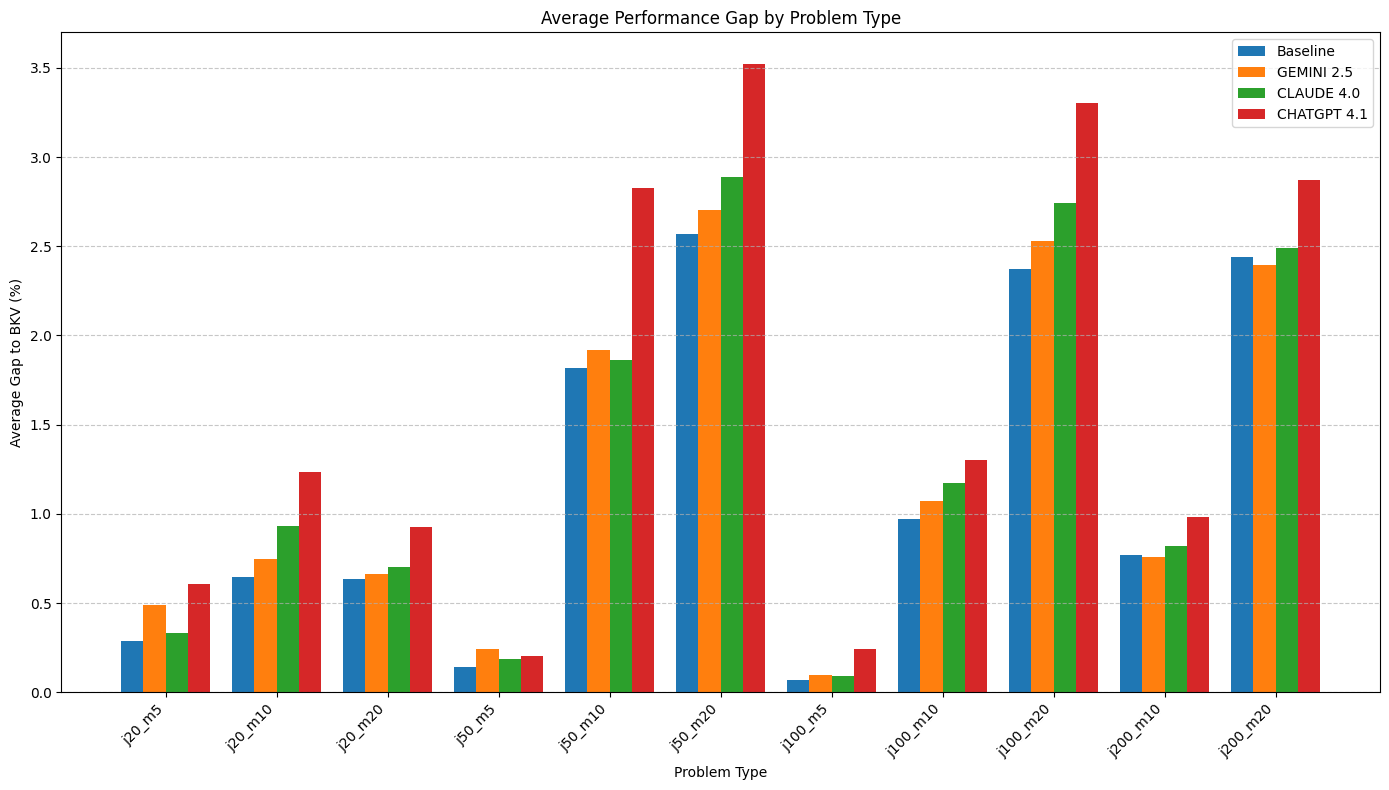

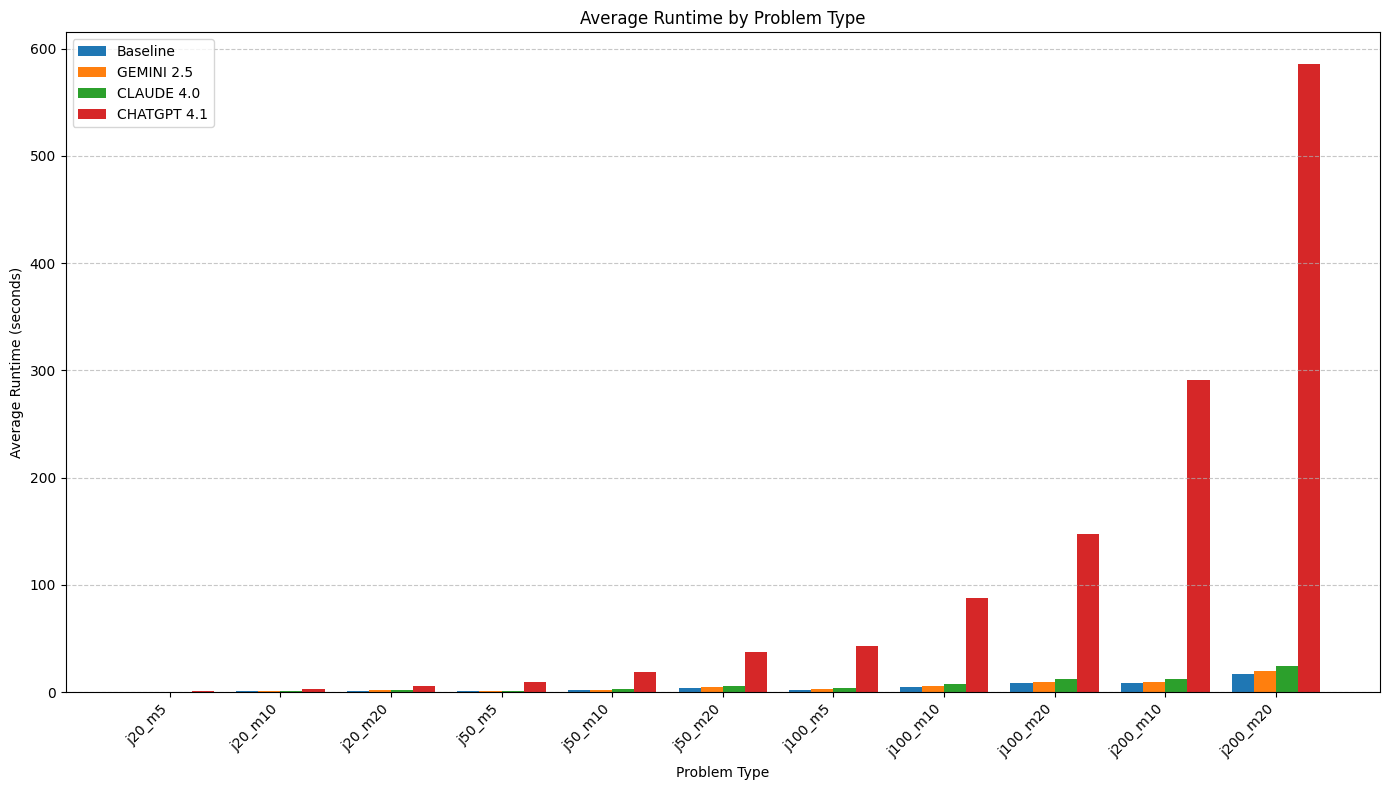

,Problem_Type,Baseline_AvgGap,GEMINI 2.5_AvgGap,CLAUDE 4.0_AvgGap,CHATGPT 4.1_AvgGap
0,j20_m5,0.286975,0.488498,0.331746,0.607049
1,j20_m10,0.645878,0.747172,0.932216,1.233121
2,j20_m20,0.636967,0.665752,0.701266,0.924631
3,j50_m5,0.143725,0.243941,0.184779,0.205563
4,j50_m10,1.817403,1.921274,1.861149,2.824168
5,j50_m20,2.566757,2.701014,2.888890,3.523129
6,j100_m5,0.070988,0.094210,0.088648,0.243926
7,j100_m10,0.970819,1.074204,1.171946,1.302440
8,j100_m20,2.375296,2.530266,2.744708,3.305700
9,j200_m10,0.769759,0.757025,0.818381,0.982536


,Approach,Avg Gap (%),Best Gap (%),Worst Gap (%),Avg Time (s)
0,Baseline,1.156768,-0.215433,3.338843,4.731281
1,GEMINI 2.5,1.237860,-0.019585,3.823934,5.402249
2,CLAUDE 4.0,1.292369,-0.137094,3.909410,6.930128
3,CHATGPT 4.1,1.638750,0.000000,4.238456,112.003767


,Instance,Problem_Type,Size,BKV,Baseline_Obj,Baseline_Gap,Baseline_Time,GEMINI 2.5_Obj,GEMINI 2.5_Gap,GEMINI 2.5_Time,CLAUDE 4.0_Obj,CLAUDE 4.0_Gap,CLAUDE 4.0_Time,CHATGPT 4.1_Obj,CHATGPT 4.1_Gap,CHATGPT 4.1_Time
0,j20_m5_01,j20_m5,20x5,1278,1278,0.000000,0.450394,1278,0.000000,0.588810,1279,0.078247,0.642459,1279,0.078247,1.501882
1,j20_m5_02,j20_m5,20x5,1359,1360,0.073584,0.443650,1360,0.073584,0.565990,1365,0.441501,0.671464,1361,0.147167,1.662633
2,j20_m5_03,j20_m5,20x5,1081,1086,0.462535,0.497414,1081,0.000000,0.553693,1081,0.000000,0.679157,1081,0.000000,1.503586
3,j20_m5_04,j20_m5,20x5,1293,1299,0.464037,0.436983,1299,0.464037,0.457127,1299,0.464037,0.649668,1301,0.618716,1.480338
4,j20_m5_05,j20_m5,20x5,1236,1243,0.566343,0.440131,1244,0.647249,0.482336,1239,0.242718,0.740548,1250,1.132686,1.690270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,j200_m20_06,j200_m20,200x20,11282,11544,2.322283,17.679869,11538,2.269101,19.106273,11505,1.976600,24.543667,11620,2.995923,592.339655
106,j200_m20_07,j200_m20,200x20,11456,11750,2.566341,16.192401,11720,2.304469,17.369830,11735,2.435405,26.120346,11801,3.011522,607.267777
107,j200_m20_08,j200_m20,200x20,11415,11698,2.479194,18.190219,11712,2.601840,21.830681,11799,3.363995,23.468621,11806,3.425318,573.694042
108,j200_m20_09,j200_m20,200x20,11343,11610,2.353875,16.646201,11615,2.397955,20.513680,11606,2.318611,24.887223,11704,3.182580,610.497846


In [25]:
def run_benchmark(data_files, approaches, seed=SEED, iters=8000):
    """
    Benchmark different ALNS approaches on multiple problem instances.
    
    Args:
        data_files: List of paths to problem instance files
        approaches: Dictionary mapping approach names to lists of (destroy_ops, repair_ops)
        seed: Random seed for reproducibility
        iters: Number of iterations for each ALNS run
    
    Returns:
        Dictionary containing all benchmark results
    """
    results = {
        'instance_names': [],
        'instance_sizes': [],
        'problem_types': [],
        'best_known_values': [],
    }
    
    # Initialize results dictionary for each approach
    for approach_name in approaches:
        results[f'{approach_name}_objectives'] = []
        results[f'{approach_name}_gaps'] = []
        results[f'{approach_name}_times'] = []
        results[f'{approach_name}_results'] = []  # Store the ALNS result objects
    
    for data_file in data_files:
        # Extract instance name from file path
        instance_name = data_file.split('/')[-1].split('.')[0]
        problem_type = data_file.split('/')[-2]
        print(f"\nProcessing instance: {instance_name} (Type: {problem_type})")
        
        # Load data
        data = Data.from_file(data_file)
        global DATA  # Use global DATA variable for the operators
        DATA = data
        
        results['instance_names'].append(instance_name)
        results['problem_types'].append(problem_type)
        results['instance_sizes'].append(f"{data.n_jobs}x{data.n_machines}")
        results['best_known_values'].append(data.bkv)
        
        # Create initial solution using NEH
        init = NEH(data.processing_times)
        
        # Run each approach
        for approach_name, (destroy_ops, repair_ops) in approaches.items():
            print(f"  Running {approach_name}...")
            
            # Setup ALNS
            alns = ALNS(rnd.default_rng(seed))
            
            # Add destroy operators
            for destroy_op in destroy_ops:
                alns.add_destroy_operator(destroy_op)
            
            # Add repair operators
            for repair_op in repair_ops:
                alns.add_repair_operator(repair_op)
            
            # Configure ALNS parameters
            select = AlphaUCB(
                scores=[5, 2, 1, 0.5],
                alpha=0.05,
                num_destroy=len(alns.destroy_operators),
                num_repair=len(alns.repair_operators),
            )
            accept = SimulatedAnnealing.autofit(init.objective(), 0.05, 0.50, iters)
            stop = MaxIterations(iters)
            
            # Add time tracking
            time_stop = MaxRuntime(3600)  # 1 hour max runtime
            
            # Run ALNS
            start_time = time.time()
            result = alns.iterate(deepcopy(init), select, accept, stop)
            runtime = time.time() - start_time
            
            # Record results
            objective = result.best_state.objective()
            gap = 100 * (objective - data.bkv) / data.bkv
            
            results[f'{approach_name}_objectives'].append(objective)
            results[f'{approach_name}_gaps'].append(gap)
            results[f'{approach_name}_times'].append(runtime)
            results[f'{approach_name}_results'].append(result)  # Store the ALNS result object
            
            print(f"    Objective: {objective}, Gap: {gap:.2f}%, Time: {runtime:.2f}s")
    
    return results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Assuming this is used in a Jupyter environment

def visualize_results(results):
    """
    Create visualizations and tables to compare the approaches,
    sorted by Problem_Type from smallest to largest.
    """
    approach_names = [name.split('_')[0] for name in results.keys() 
                     if name.endswith('_objectives')]
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'Instance': results['instance_names'],
        'Problem_Type': results['problem_types'],
        'Size': results['instance_sizes'],
        'BKV': results['best_known_values']
    })
    
    for approach in approach_names:
        df[f'{approach}_Obj'] = results[f'{approach}_objectives']
        df[f'{approach}_Gap'] = results[f'{approach}_gaps']
        df[f'{approach}_Time'] = results[f'{approach}_times']

    # Define the desired order for Problem_Type (smallest to largest)
    problem_type_order = [
        'j20_m5', 'j20_m10', 'j20_m20',
        'j50_m5', 'j50_m10', 'j50_m20',
        'j100_m5', 'j100_m10', 'j100_m20',
        'j200_m10', 'j200_m20',
        'j500_m20'
    ]
    
    # Ensure all problem types in the DataFrame are covered by the categorical ordering
    current_problem_types_in_data = df['Problem_Type'].unique()
    
    # Create the list of categories for pd.Categorical:
    # Start with types from problem_type_order that are actually in the data, preserving order
    ordered_categories = [ptype for ptype in problem_type_order if ptype in current_problem_types_in_data]
    
    # Add any problem types found in data but not in problem_type_order to the end of the list
    # This makes them appear last, but the known types are correctly ordered.
    for ptype in current_problem_types_in_data:
        if ptype not in ordered_categories:
            ordered_categories.append(ptype)
            
    df['Problem_Type'] = pd.Categorical(df['Problem_Type'], categories=ordered_categories, ordered=True)

    # --- 1. Problem type average gap comparison (Graph) ---
    plt.figure(figsize=(14, 8))
    
    problem_type_avg = df.groupby('Problem_Type', observed=False).agg(
        **{f"{approach}_AvgGap": pd.NamedAgg(column=f"{approach}_Gap", aggfunc="mean") for approach in approach_names}
    ).reset_index()
    
    # Explicitly sort by the categorical 'Problem_Type'
    problem_type_avg = problem_type_avg.sort_values(by='Problem_Type')
        
    problem_types_for_plot = problem_type_avg['Problem_Type']
    x_indices = np.arange(len(problem_types_for_plot))
    num_approaches = len(approach_names)
    bar_width = 0.8 / num_approaches
    
    for i, approach in enumerate(approach_names):
        offset = i * bar_width - (0.8 / 2) + (bar_width / 2)
        plt.bar(x_indices + offset, problem_type_avg[f'{approach}_AvgGap'], 
                width=bar_width, label=approach)
    
    plt.xlabel('Problem Type')
    plt.ylabel('Average Gap to BKV (%)')
    plt.title('Average Performance Gap by Problem Type')
    plt.xticks(x_indices, problem_types_for_plot, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # --- 2. Problem type average runtime comparison (Graph) ---
    plt.figure(figsize=(14, 8))
    
    problem_type_avg_time = df.groupby('Problem_Type', observed=False).agg(
        **{f"{approach}_AvgTime": pd.NamedAgg(column=f"{approach}_Time", aggfunc="mean") for approach in approach_names}
    ).reset_index()

    # Explicitly sort by the categorical 'Problem_Type'
    problem_type_avg_time = problem_type_avg_time.sort_values(by='Problem_Type')
            
    problem_types_for_time_plot = problem_type_avg_time['Problem_Type']
    x_indices_time = np.arange(len(problem_types_for_time_plot))

    for i, approach in enumerate(approach_names):
        offset = i * bar_width - (0.8 / 2) + (bar_width / 2)
        plt.bar(x_indices_time + offset, problem_type_avg_time[f'{approach}_AvgTime'], 
                width=bar_width, label=approach)
    
    plt.xlabel('Problem Type')
    plt.ylabel('Average Runtime (seconds)')
    plt.title('Average Runtime by Problem Type')
    plt.xticks(x_indices_time, problem_types_for_time_plot, rotation=45, ha="right")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # --- 3. Summary table by problem type ---
    # problem_type_avg is already sorted correctly by 'Problem_Type'
    summary_table = problem_type_avg.copy() # Use the already sorted problem_type_avg
    # If you need only specific columns or a different format:
    # summary_display = summary_table[['Problem_Type'] + [f'{approach}_AvgGap' for approach in approach_names]]
    display(summary_table) 
    
    # --- 4. Overall summary table (order does not depend on Problem_Type) ---
    overall_summary_list = []
    for approach in approach_names:
        overall_summary_list.append({
            'Approach': approach,
            'Avg Gap (%)': df[f'{approach}_Gap'].mean(),
            'Best Gap (%)': df[f'{approach}_Gap'].min(),
            'Worst Gap (%)': df[f'{approach}_Gap'].max(),
            'Avg Time (s)': df[f'{approach}_Time'].mean(),
        })
    overall_summary_df = pd.DataFrame(overall_summary_list)
    display(overall_summary_df)
    
    # --- 5. Detailed results table ---
    # Sort the main DataFrame 'df' by the categorical 'Problem_Type', then 'Instance'
    df_sorted_detailed = df.sort_values(by=['Problem_Type', 'Instance'])
    display(df_sorted_detailed)
    
    return df_sorted_detailed

if __name__ == "__main__":
    import time
    import pandas as pd
    
    # Define the approaches to compare
    approaches = {
        'Baseline': (
            [random_removal, adjacent_removal],  # destroy operators
            [greedy_repair]    # repair operators
        ),
        'GEMINI 2.5': (
            [random_removal, adjacent_removal],  # destroy operators
            [llm_greedy_repair_random_order, 
             llm_lpt_priority_repair, 
             llm_spt_priority_repair, 
             llm_regret_k_repair, 
             llm_random_slot_repair]  
        ),
        'CLAUDE 4.0': (
            [random_removal, adjacent_removal],  # destroy operators
            [llm_repair]    # repair operators
        ),
        'CHATGPT 4.1': (
            [random_removal, adjacent_removal],  # destroy operators
            [gpt_llm_repair]    # repair operators
        )
        
    }
    
data_files = []

# All configurations of (jobs, machines)
configurations = [
    (20, 5), (20, 10), (20, 20),
    (50, 5), (50, 10), (50, 20),
    (100, 5), (100, 10), (100, 20),
    (200, 10), (200, 20),
]

# Generate all file paths in a nested loop
for jobs, machines in configurations:
    for i in range(1, 11):
        data_files.append(f"data/j{jobs}_m{machines}/j{jobs}_m{machines}_{i:02d}.txt")
    
# Run the benchmark
results = run_benchmark(data_files, approaches, seed=SEED, iters=600)

# Visualize and analyze the results
results_df = visualize_results(results)

# Save results to CSV
results_df.to_csv('alns_operator_selection_results.csv', index=False)

Available models: ['Baseline', 'GEMINI 2.5', 'CLAUDE 4.0', 'CHATGPT 4.1']
Available problem types: ['j100_m10', 'j100_m20', 'j100_m5', 'j200_m10', 'j200_m20', 'j20_m10', 'j20_m20', 'j20_m5', 'j50_m10', 'j50_m20', 'j50_m5']

=== Average Runtime for Each Model by Problem Size ===
              Baseline_AvgRuntime(s)  GEMINI 2.5_AvgRuntime(s)  \
Problem_Type                                                     
j20_m5                        0.4596                    0.5161   
j20_m10                       0.8321                    0.9134   
j20_m20                       1.5821                    1.8984   
j50_m5                        1.1517                    1.2378   
j50_m10                       2.1134                    2.4333   
j50_m20                       4.1892                    4.7352   
j100_m5                       2.4002                    2.6344   
j100_m10                      5.0980                    5.8434   
j100_m20                      8.5021                    9.760

/var/folders/c1/2pvb93r92ks0tgggmmbgflnc0000gn/T/ipykernel_54414/3639520904.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_summary = df.groupby('Problem_Type').agg({
/var/folders/c1/2pvb93r92ks0tgggmmbgflnc0000gn/T/ipykernel_54414/3639520904.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detailed_runtime_summary = df.groupby('Problem_Type').agg({


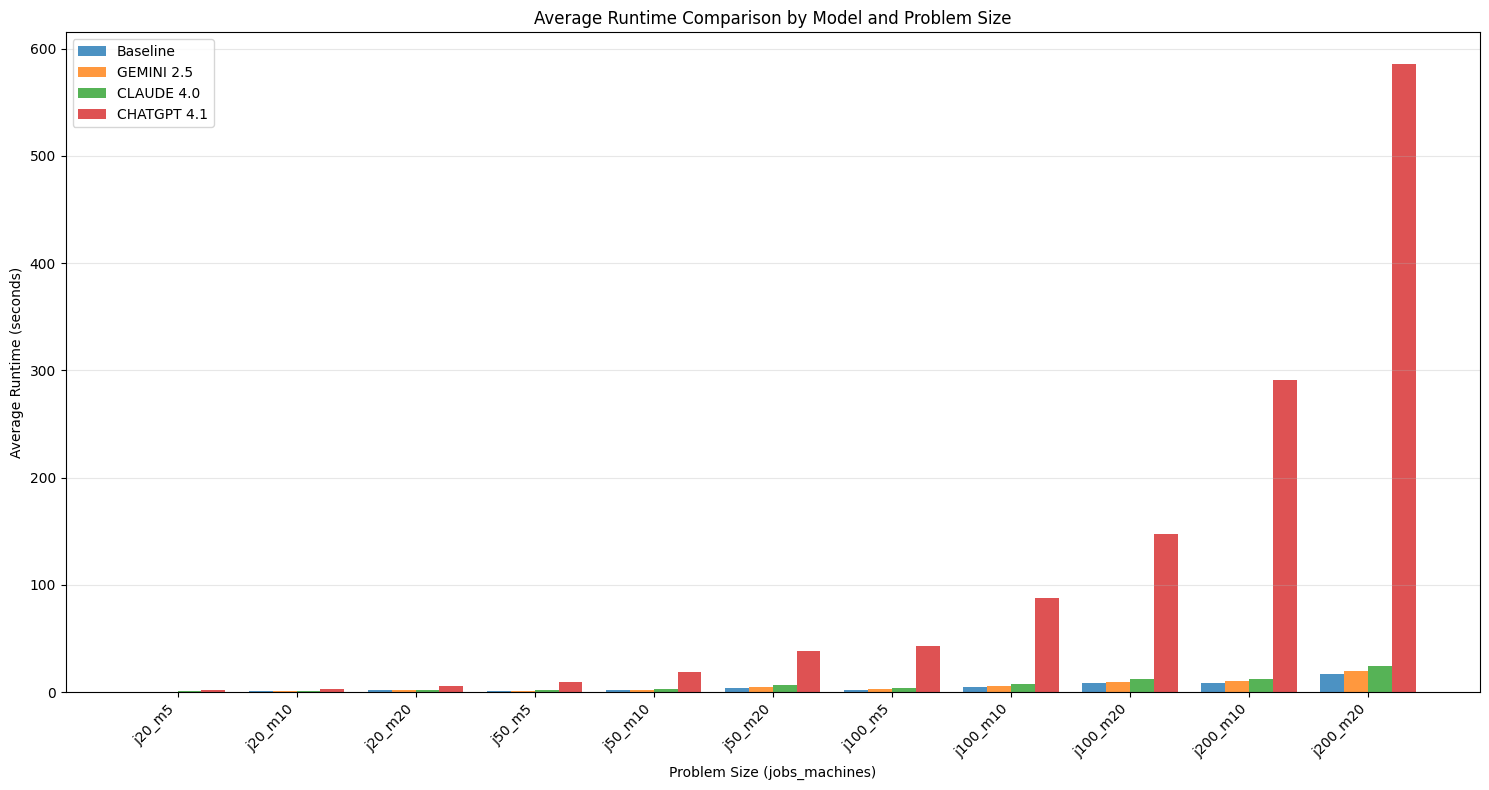


=== Pivot Table: Average Runtime by Model and Problem Size ===
              Baseline_Time  CHATGPT 4.1_Time  CLAUDE 4.0_Time  \
Problem_Type                                                     
j20_m5               0.4596            1.6082           0.6757   
j20_m10              0.8321            3.0446           1.2325   
j20_m20              1.5821            5.9196           2.2594   
j50_m5               1.1517            9.6414           1.6286   
j50_m10              2.1134           18.7885           3.1642   
j50_m20              4.1892           37.9097           6.3216   
j100_m5              2.4002           43.0460           3.8968   
j100_m10             5.0980           87.4466           7.9343   
j100_m20             8.5021          147.7182          12.5303   
j200_m10             8.5328          291.1041          12.1021   
j200_m20            17.1829          585.8146          24.4858   

              GEMINI 2.5_Time  
Problem_Type                   
j20_m5       

/var/folders/c1/2pvb93r92ks0tgggmmbgflnc0000gn/T/ipykernel_54414/3639520904.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_runtime = df.pivot_table(


In [26]:
# Code to calculate average runtime for each model for each problem size

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already run the benchmark and have the results
# If you haven't run the benchmark yet, you need to run the main execution block first

# If results_df already exists from running the benchmark:
if 'results_df' in locals():
    df = results_df
else:
    # If you need to load from CSV (if it was saved previously)
    try:
        df = pd.read_csv('alns_operator_selection_results.csv')
    except FileNotFoundError:
        print("Results not found. Please run the benchmark first.")
        # You would need to run the benchmark code here
        
# Extract model names (approaches)
approach_columns = [col for col in df.columns if col.endswith('_Time')]
model_names = [col.replace('_Time', '') for col in approach_columns]

print("Available models:", model_names)
print("Available problem types:", sorted(df['Problem_Type'].unique()))

# Calculate average runtime for each model for each problem size
runtime_summary = df.groupby('Problem_Type').agg({
    f'{model}_Time': 'mean' for model in model_names
}).round(4)

# Rename columns for better readability
runtime_summary.columns = [f'{model}_AvgRuntime(s)' for model in model_names]

print("\n=== Average Runtime for Each Model by Problem Size ===")
print(runtime_summary)

# Create a more detailed summary with additional statistics
detailed_runtime_summary = df.groupby('Problem_Type').agg({
    **{f'{model}_Time': ['mean', 'std', 'min', 'max'] for model in model_names}
}).round(4)

# Flatten column names
detailed_runtime_summary.columns = [f'{model}_{stat}' for model, stat in detailed_runtime_summary.columns]

print("\n=== Detailed Runtime Statistics by Problem Size ===")
print(detailed_runtime_summary)

# Create a visualization
plt.figure(figsize=(15, 8))

# Prepare data for plotting
problem_types = runtime_summary.index
x_pos = np.arange(len(problem_types))
bar_width = 0.8 / len(model_names)

# Plot bars for each model
for i, model in enumerate(model_names):
    offset = i * bar_width - (0.8 / 2) + (bar_width / 2)
    plt.bar(x_pos + offset, runtime_summary[f'{model}_AvgRuntime(s)'], 
            width=bar_width, label=model, alpha=0.8)

plt.xlabel('Problem Size (jobs_machines)')
plt.ylabel('Average Runtime (seconds)')
plt.title('Average Runtime Comparison by Model and Problem Size')
plt.xticks(x_pos, problem_types, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Create a pivot table for easy comparison
pivot_runtime = df.pivot_table(
    values=[f'{model}_Time' for model in model_names],
    index='Problem_Type',
    aggfunc='mean'
).round(4)

print("\n=== Pivot Table: Average Runtime by Model and Problem Size ===")
print(pivot_runtime)

# Calculate overall average runtime for each model
overall_avg_runtime = {model: df[f'{model}_Time'].mean() for model in model_names}

print("\n=== Overall Average Runtime by Model ===")
for model, avg_time in overall_avg_runtime.items():
    print(f"{model}: {avg_time:.4f} seconds")

# Create a summary DataFrame for export
summary_for_export = runtime_summary.copy()
summary_for_export.index.name = 'Problem_Size'
summary_for_export = summary_for_export.reset_index()

print("\n=== Summary Table for Export ===")
print(summary_for_export)

# Save the runtime summary to CSV
summary_for_export.to_csv('average_runtime_by_model_and_problem_size.csv', index=False)
print("\nRuntime summary saved to 'average_runtime_by_model_and_problem_size.csv'")